In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

\begin{align*}
0 = \max_{e} \min_{h_2} & -\delta \phi(y, z_2) + \delta \eta \log e - \delta(1-\eta) \left(\gamma_1 y z_2 + \frac{\gamma_2}{2}y^2z_2^2 \right) + \xi_m\frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e  \\
& + \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho (z_2 -\mu_2) + \sqrt{z_2} \sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial(z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)
\end{align*}

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\sqrt{z_2}\sigma_2}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2)}
$$

In [30]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2, γ_2p, γ_bar = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = -δ*η / v0_dy
        e[e<=0] = 1e-10
        h = -v0_dz*np.sqrt(z_mat)*σ_2 / ξ_m

        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) - δ*(1-η)*(γ_1*y_mat*z_mat+γ_2/2.*y_mat**2*z_mat**2
                                     +γ_2p/2.*(y_mat*z_mat>γ_bar)*(y_mat*z_mat-γ_bar)**2) + ξ_m*h**2/2

        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [39]:
# Model parameters
η = .032
# ξ_m = .00256
ξ_m = 1000.
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
γ_1 = 1.7675/10000
γ_2 = 0.0022*2
# γ_2p = 0.
γ_2p = 0.0197*2
γ_bar = 2.

pde_paras = (η, ξ_m, δ, η, μ_2, ρ, σ_2, γ_1, γ_2, γ_2p, γ_bar)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 100
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 50
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [40]:
ϕ_grid, e_grid = false_transient(z_grid, y_grid, model_paras=pde_paras, v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.007795032326670004; RHS Error 0.008409363921605692
Iteration 2: LHS Error: 0.007280679710580884; RHS Error 0.0077586301456675985
Iteration 3: LHS Error: 0.006888412893250262; RHS Error 0.00724624173175128
Iteration 4: LHS Error: 0.006594056425998307; RHS Error 0.006855449270198635
Iteration 5: LHS Error: 0.00637438929413392; RHS Error 0.006562193067691533
Iteration 6: LHS Error: 0.006209977429125546; RHS Error 0.00634334906590063
Iteration 7: LHS Error: 0.006085646849851578; RHS Error 0.0061810255378213115
Iteration 8: LHS Error: 0.005989957604587204; RHS Error 0.0060589911675455665
Iteration 9: LHS Error: 0.005914595899835895; RHS Error 0.005964971053251253
Iteration 10: LHS Error: 0.005853547080430843; RHS Error 0.005890822562628481
Iteration 11: LHS Error: 0.005802540018991831; RHS Error 0.005830663941997891
Iteration 12: LHS Error: 0.005758556007691595; RHS Error 0.005780319188672285
Iteration 13: LHS Error: 0.005719505091775545; RHS Error 0.00573683894002

Iteration 107: LHS Error: 0.0035697396266956005; RHS Error 0.0035772447671409465
Iteration 108: LHS Error: 0.0035520400452537793; RHS Error 0.0035595455281455454
Iteration 109: LHS Error: 0.0035344282219640366; RHS Error 0.0035419340032472736
Iteration 110: LHS Error: 0.003516903742396549; RHS Error 0.003524409802988248
Iteration 111: LHS Error: 0.003499466181453803; RHS Error 0.003506972510269839
Iteration 112: LHS Error: 0.0034821151092623293; RHS Error 0.003489621707028985
Iteration 113: LHS Error: 0.003464850095309391; RHS Error 0.0034723569596625684
Iteration 114: LHS Error: 0.003447670708807582; RHS Error 0.0034551778454667286
Iteration 115: LHS Error: 0.0034305765223874296; RHS Error 0.003438083930859561
Iteration 116: LHS Error: 0.0034135671105717247; RHS Error 0.00342107479257662
Iteration 117: LHS Error: 0.003396642050445653; RHS Error 0.0034041500047444066
Iteration 118: LHS Error: 0.003379800921851528; RHS Error 0.0033873091497713115
Iteration 119: LHS Error: 0.003363043307

Iteration 211: LHS Error: 0.0021288264129575296; RHS Error 0.0021363555711429857
Iteration 212: LHS Error: 0.00211827177317514; RHS Error 0.002125801108437903
Iteration 213: LHS Error: 0.0021077694662225976; RHS Error 0.0021152989796474403
Iteration 214: LHS Error: 0.002097319232291728; RHS Error 0.0021048489243369857
Iteration 215: LHS Error: 0.0020869208131586436; RHS Error 0.0020944506801571427
Iteration 216: LHS Error: 0.0020765739519044146; RHS Error 0.0020841039943622235
Iteration 217: LHS Error: 0.002066278395736587; RHS Error 0.002073808608344637
Iteration 218: LHS Error: 0.002056033886612907; RHS Error 0.0020635642769163782
Iteration 219: LHS Error: 0.0020458401712553087; RHS Error 0.002053370735059778
Iteration 220: LHS Error: 0.002035696998180292; RHS Error 0.002043227730279933
Iteration 221: LHS Error: 0.002025604116999258; RHS Error 0.002033135018268855
Iteration 222: LHS Error: 0.002015561278336353; RHS Error 0.002023092350050339
Iteration 223: LHS Error: 0.00200556823406

Iteration 314: LHS Error: 0.0012758838409884232; RHS Error 0.001283427535666762
Iteration 315: LHS Error: 0.001269558202454446; RHS Error 0.0012771020085662317
Iteration 316: LHS Error: 0.001263263925124547; RHS Error 0.0012708078401890682
Iteration 317: LHS Error: 0.0012570008555685686; RHS Error 0.0012645448786335963
Iteration 318: LHS Error: 0.0012507688362256575; RHS Error 0.0012583129671422813
Iteration 319: LHS Error: 0.0012445677139361067; RHS Error 0.0012521119545765868
Iteration 320: LHS Error: 0.001238397336919217; RHS Error 0.0012459416802239895
Iteration 321: LHS Error: 0.0012322575531851232; RHS Error 0.0012398020040742441
Iteration 322: LHS Error: 0.0012261482099232834; RHS Error 0.0012336927667158943
Iteration 323: LHS Error: 0.0012200691570619648; RHS Error 0.0012276138154251352
Iteration 324: LHS Error: 0.001214020243590408; RHS Error 0.0012215650055215892
Iteration 325: LHS Error: 0.001208001321104657; RHS Error 0.0012155461833964895
Iteration 326: LHS Error: 0.001202

Iteration 416: LHS Error: 0.0007684990881450249; RHS Error 0.0007760516681039703
Iteration 417: LHS Error: 0.0007646890297748898; RHS Error 0.0007722416772826033
Iteration 418: LHS Error: 0.0007608978622227758; RHS Error 0.000768450576741827
Iteration 419: LHS Error: 0.0007571254907375868; RHS Error 0.0007646782739693245
Iteration 420: LHS Error: 0.0007533718215468888; RHS Error 0.0007609246710247961
Iteration 421: LHS Error: 0.0007496367629915568; RHS Error 0.0007571896804117998
Iteration 422: LHS Error: 0.0007459202219447514; RHS Error 0.0007534732023760728
Iteration 423: LHS Error: 0.0007422221073529744; RHS Error 0.0007497751539703699
Iteration 424: LHS Error: 0.0007385423278253311; RHS Error 0.0007460954402856193
Iteration 425: LHS Error: 0.0007348807918878819; RHS Error 0.000742433971011245
Iteration 426: LHS Error: 0.0007312374088828122; RHS Error 0.0007387919299229849
Iteration 427: LHS Error: 0.000727612089987284; RHS Error 0.0007351741558172748
Iteration 428: LHS Error: 0.000

Iteration 518: LHS Error: 0.00046288962902607533; RHS Error 0.00047099988133400203
Iteration 519: LHS Error: 0.00046059472799975243; RHS Error 0.0004687097185412225
Iteration 520: LHS Error: 0.00045831120492223487; RHS Error 0.00046643090634569933
Iteration 521: LHS Error: 0.00045603900355373206; RHS Error 0.00046416339368750975
Iteration 522: LHS Error: 0.000453778067219468; RHS Error 0.0004619071187225328
Iteration 523: LHS Error: 0.0004515284215692583; RHS Error 0.000459662031644297
Iteration 524: LHS Error: 0.00044928983071590434; RHS Error 0.0004574280899013036
Iteration 525: LHS Error: 0.00044706232293156845; RHS Error 0.0004552051713872154
Iteration 526: LHS Error: 0.0004448458088468499; RHS Error 0.0004529932920529084
Iteration 527: LHS Error: 0.00044264042042241325; RHS Error 0.0004507923730663853
Iteration 528: LHS Error: 0.00044044589434943937; RHS Error 0.00044860242483936354
Iteration 529: LHS Error: 0.00043826228514098897; RHS Error 0.0004464232691228703
Iteration 530: LH

Iteration 619: LHS Error: 0.00028020148791307875; RHS Error 0.000288958315167699
Iteration 620: LHS Error: 0.0002788123171533208; RHS Error 0.0002875748254604453
Iteration 621: LHS Error: 0.000277430032472048; RHS Error 0.0002861981883133585
Iteration 622: LHS Error: 0.00027605460331114884; RHS Error 0.0002848283803912593
Iteration 623: LHS Error: 0.0002746859878081098; RHS Error 0.0002834653604837272
Iteration 624: LHS Error: 0.00027332416165859463; RHS Error 0.0002821090993621444
Iteration 625: LHS Error: 0.0002719690845617295; RHS Error 0.0002807595571203327
Iteration 626: LHS Error: 0.0002706207275404715; RHS Error 0.0002794167117652468
Iteration 627: LHS Error: 0.0002692790558437297; RHS Error 0.00027808052173724715
Iteration 628: LHS Error: 0.00026794403466912087; RHS Error 0.0002767509520845181
Iteration 629: LHS Error: 0.0002666156312624013; RHS Error 0.00027542797613258445
Iteration 630: LHS Error: 0.0002652938161533669; RHS Error 0.0002741115577432063
Iteration 631: LHS Error

Iteration 719: LHS Error: 0.00017045996290443455; RHS Error 0.00017978492053083352
Iteration 720: LHS Error: 0.00016961486331823483; RHS Error 0.00017894497244911288
Iteration 721: LHS Error: 0.00016877395526848638; RHS Error 0.00017810918767670065
Iteration 722: LHS Error: 0.00016793721483598922; RHS Error 0.00017727754624387564
Iteration 723: LHS Error: 0.0001671046233586715; RHS Error 0.0001764500255274446
Iteration 724: LHS Error: 0.00016627616193631845; RHS Error 0.00017562660757707536
Iteration 725: LHS Error: 0.00016545180559301986; RHS Error 0.00017480727057470925
Iteration 726: LHS Error: 0.00016463153452472845; RHS Error 0.00017399199570694926
Iteration 727: LHS Error: 0.00016381533531650838; RHS Error 0.0001731807578552345
Iteration 728: LHS Error: 0.0001630031792090314; RHS Error 0.00017237354726576393
Iteration 729: LHS Error: 0.00016219504939030127; RHS Error 0.00017157033594941348
Iteration 730: LHS Error: 0.00016139092648415065; RHS Error 0.00017077110814617876
Iteratio

Iteration 819: LHS Error: 0.00010369911668095533; RHS Error 0.00011346106136166014
Iteration 820: LHS Error: 0.00010318517139018546; RHS Error 0.00011295109906494637
Iteration 821: LHS Error: 0.00010267364406524315; RHS Error 0.00011244369966657321
Iteration 822: LHS Error: 0.0001021645132358584; RHS Error 0.00011193872407235916
Iteration 823: LHS Error: 0.00010165777520887431; RHS Error 0.00011143634540610337
Iteration 824: LHS Error: 0.00010115426932866267; RHS Error 0.00011093640201839585
Iteration 825: LHS Error: 0.00010065249588442349; RHS Error 0.00011043890837654849
Iteration 826: LHS Error: 0.00010015367313231938; RHS Error 0.00010994396591874466
Iteration 827: LHS Error: 9.96569007378767e-05; RHS Error 0.00010945138549164034
Iteration 828: LHS Error: 9.916295343459502e-05; RHS Error 0.0001089613027159585
Iteration 829: LHS Error: 9.867105814964638e-05; RHS Error 0.00010847367800771637
Iteration 830: LHS Error: 9.818231353020401e-05; RHS Error 0.00010798841871055304
Iteration 8

Iteration 921: LHS Error: 6.246104127305419e-05; RHS Error 7.255380276622453e-05
Iteration 922: LHS Error: 6.215138094933792e-05; RHS Error 7.224660451191165e-05
Iteration 923: LHS Error: 6.184324526847806e-05; RHS Error 7.19409261116348e-05
Iteration 924: LHS Error: 6.153664033548001e-05; RHS Error 7.163677118863371e-05
Iteration 925: LHS Error: 6.123155643822376e-05; RHS Error 7.133411673300016e-05
Iteration 926: LHS Error: 6.092798028545232e-05; RHS Error 7.103296518675209e-05
Iteration 927: LHS Error: 6.062591969502318e-05; RHS Error 7.073330393103476e-05
Iteration 928: LHS Error: 6.0325350361156715e-05; RHS Error 7.043513124348633e-05
Iteration 929: LHS Error: 6.002626722323434e-05; RHS Error 7.013843349423874e-05
Iteration 930: LHS Error: 5.972867007641991e-05; RHS Error 6.984320994504745e-05
Iteration 931: LHS Error: 5.94325528250339e-05; RHS Error 6.95494447051177e-05
Iteration 932: LHS Error: 5.913789884615106e-05; RHS Error 6.925714255645934e-05
Iteration 933: LHS Error: 5.88

Iteration 1023: LHS Error: 3.767949533373116e-05; RHS Error 4.7947064219488566e-05
Iteration 1024: LHS Error: 3.746569591700499e-05; RHS Error 4.776221134252347e-05
Iteration 1025: LHS Error: 3.7248771912468115e-05; RHS Error 4.7578520141829616e-05
Iteration 1026: LHS Error: 3.70638323760053e-05; RHS Error 4.739586540285169e-05
Iteration 1027: LHS Error: 3.687998443679952e-05; RHS Error 4.721385820503801e-05
Iteration 1028: LHS Error: 3.66970768550523e-05; RHS Error 4.703277753200755e-05
Iteration 1029: LHS Error: 3.651506210344824e-05; RHS Error 4.685261946605387e-05
Iteration 1030: LHS Error: 3.6394374682946484e-05; RHS Error 4.667335811961773e-05
Iteration 1031: LHS Error: 3.615422539637869e-05; RHS Error 4.649483637555129e-05
Iteration 1032: LHS Error: 3.601979338163641e-05; RHS Error 4.631756861917468e-05
Iteration 1033: LHS Error: 3.5796424284639805e-05; RHS Error 4.614077035403096e-05
Iteration 1034: LHS Error: 3.566069580795972e-05; RHS Error 4.5965253132532647e-05
Iteration 10

Iteration 1123: LHS Error: 2.2885977187914186e-05; RHS Error 3.498949045506679e-05
Iteration 1124: LHS Error: 2.277251205751174e-05; RHS Error 3.489066828413689e-05
Iteration 1125: LHS Error: 2.265960977121395e-05; RHS Error 3.479232027383481e-05
Iteration 1126: LHS Error: 2.254726763606385e-05; RHS Error 3.469443627658702e-05
Iteration 1127: LHS Error: 2.243548242097937e-05; RHS Error 3.459701700645662e-05
Iteration 1128: LHS Error: 2.2324250598004802e-05; RHS Error 3.450006342841733e-05
Iteration 1129: LHS Error: 2.2213571997053982e-05; RHS Error 3.4403564583785175e-05
Iteration 1130: LHS Error: 2.2103440730725232e-05; RHS Error 3.430753121185754e-05
Iteration 1131: LHS Error: 2.1993856866076023e-05; RHS Error 3.4211948834636825e-05
Iteration 1132: LHS Error: 2.1884815646466826e-05; RHS Error 3.411681749818392e-05
Iteration 1133: LHS Error: 2.1776315086374787e-05; RHS Error 3.4022147152311204e-05
Iteration 1134: LHS Error: 2.1668351091630456e-05; RHS Error 3.392792119280612e-05
Itera

Iteration 1223: LHS Error: 1.3922552876355354e-05; RHS Error 2.711865404579042e-05
Iteration 1224: LHS Error: 1.3853323383328231e-05; RHS Error 2.7057709002929184e-05
Iteration 1225: LHS Error: 1.3784899040247822e-05; RHS Error 2.6997023042557675e-05
Iteration 1226: LHS Error: 1.3716318983503228e-05; RHS Error 2.6936703129812106e-05
Iteration 1227: LHS Error: 1.3648353023310023e-05; RHS Error 2.6876592588474904e-05
Iteration 1228: LHS Error: 1.3580661779033498e-05; RHS Error 2.681681181284699e-05
Iteration 1229: LHS Error: 1.3513384873320433e-05; RHS Error 2.6757316735149855e-05
Iteration 1230: LHS Error: 1.3446384728776906e-05; RHS Error 2.6698101409445993e-05
Iteration 1231: LHS Error: 1.3379722035855579e-05; RHS Error 2.6639163152520804e-05
Iteration 1232: LHS Error: 1.3313594644182025e-05; RHS Error 2.6580509863743544e-05
Iteration 1233: LHS Error: 1.3247345055145132e-05; RHS Error 2.652216607987819e-05
Iteration 1234: LHS Error: 1.3181902461911754e-05; RHS Error 2.646403138758678e

Iteration 1323: LHS Error: 8.469826328738606e-06; RHS Error 2.2265927946096717e-05
Iteration 1324: LHS Error: 8.427834481850027e-06; RHS Error 2.2228219910471917e-05
Iteration 1325: LHS Error: 8.386054633602313e-06; RHS Error 2.219069162762323e-05
Iteration 1326: LHS Error: 8.344480641575558e-06; RHS Error 2.2153353505541425e-05
Iteration 1327: LHS Error: 8.303112513652344e-06; RHS Error 2.211618988680496e-05
Iteration 1328: LHS Error: 8.26194958336579e-06; RHS Error 2.2079201062686672e-05
Iteration 1329: LHS Error: 8.220994155982986e-06; RHS Error 2.2042392445545357e-05
Iteration 1330: LHS Error: 8.180028564730435e-06; RHS Error 2.2005766760539275e-05
Iteration 1331: LHS Error: 8.139391515560312e-06; RHS Error 2.196928290501939e-05
Iteration 1332: LHS Error: 8.099902716440788e-06; RHS Error 2.193301786925487e-05
Iteration 1333: LHS Error: 8.059150005568227e-06; RHS Error 2.1896941051379354e-05
Iteration 1334: LHS Error: 8.01925673188375e-06; RHS Error 2.1861007033231283e-05
Iteration 

Iteration 1423: LHS Error: 5.15261240652265e-06; RHS Error 1.9267753985022695e-05
Iteration 1424: LHS Error: 5.127071024513263e-06; RHS Error 1.9244494690376167e-05
Iteration 1425: LHS Error: 5.101656585071446e-06; RHS Error 1.922134798481185e-05
Iteration 1426: LHS Error: 5.076368146283983e-06; RHS Error 1.9198312325763994e-05
Iteration 1427: LHS Error: 5.051205359984934e-06; RHS Error 1.917538840751857e-05
Iteration 1428: LHS Error: 5.026167236410473e-06; RHS Error 1.9152574750955226e-05
Iteration 1429: LHS Error: 5.0012533833188044e-06; RHS Error 1.9129872942921778e-05
Iteration 1430: LHS Error: 4.97646313291078e-06; RHS Error 1.91072801270058e-05
Iteration 1431: LHS Error: 4.951795483321142e-06; RHS Error 1.9084795226344432e-05
Iteration 1432: LHS Error: 4.927250351283163e-06; RHS Error 1.906242119537353e-05
Iteration 1433: LHS Error: 4.902827082986505e-06; RHS Error 1.9040155965163508e-05
Iteration 1434: LHS Error: 4.878524645035576e-06; RHS Error 1.901799416355302e-05
Iteration 1

Iteration 1523: LHS Error: 3.1349771542066307e-06; RHS Error 1.74203449734859e-05
Iteration 1524: LHS Error: 3.119439841214877e-06; RHS Error 1.740603172908071e-05
Iteration 1525: LHS Error: 3.103979551832836e-06; RHS Error 1.7391787082789444e-05
Iteration 1526: LHS Error: 3.0885959597659607e-06; RHS Error 1.7377612099903403e-05
Iteration 1527: LHS Error: 3.0732888003370817e-06; RHS Error 1.7363506230770414e-05
Iteration 1528: LHS Error: 3.0580572480953805e-06; RHS Error 1.7349468528274554e-05
Iteration 1529: LHS Error: 3.0429013054833476e-06; RHS Error 1.7335498339265032e-05
Iteration 1530: LHS Error: 3.02782053018813e-06; RHS Error 1.7321596333891683e-05
Iteration 1531: LHS Error: 3.012814597469493e-06; RHS Error 1.7307762823240137e-05
Iteration 1532: LHS Error: 2.9978828675059077e-06; RHS Error 1.729399635654058e-05
Iteration 1533: LHS Error: 2.983025430669528e-06; RHS Error 1.7280295209241056e-05
Iteration 1534: LHS Error: 2.9682412671094838e-06; RHS Error 1.726666194236688e-05
Ite

Iteration 1623: LHS Error: 1.9075215633712617e-06; RHS Error 1.6284555033721656e-05
Iteration 1624: LHS Error: 1.8980678506697046e-06; RHS Error 1.6275764350294865e-05
Iteration 1625: LHS Error: 1.8886599223444378e-06; RHS Error 1.626701562758542e-05
Iteration 1626: LHS Error: 1.8793053774279755e-06; RHS Error 1.625831666771891e-05
Iteration 1627: LHS Error: 1.8699922588183426e-06; RHS Error 1.624965043159815e-05
Iteration 1628: LHS Error: 1.8607250570346068e-06; RHS Error 1.6241026867082e-05
Iteration 1629: LHS Error: 1.8515050507206254e-06; RHS Error 1.6232449909159763e-05
Iteration 1630: LHS Error: 1.8423291513469664e-06; RHS Error 1.6223913120794035e-05
Iteration 1631: LHS Error: 1.8331988741460137e-06; RHS Error 1.6215418087570918e-05
Iteration 1632: LHS Error: 1.8241155776976825e-06; RHS Error 1.6206966756618688e-05
Iteration 1633: LHS Error: 1.815077523614761e-06; RHS Error 1.6198555848469503e-05
Iteration 1634: LHS Error: 1.806081982080876e-06; RHS Error 1.6190182850526677e-05


Iteration 1722: LHS Error: 1.1663386965121703e-06; RHS Error 1.55929562208878e-05
Iteration 1723: LHS Error: 1.1605586199836537e-06; RHS Error 1.558754262675135e-05
Iteration 1724: LHS Error: 1.1548071244815716e-06; RHS Error 1.558215418879063e-05
Iteration 1725: LHS Error: 1.149084422169544e-06; RHS Error 1.5576792254174375e-05
Iteration 1726: LHS Error: 1.1433899892443478e-06; RHS Error 1.5571454776728324e-05
Iteration 1727: LHS Error: 1.1377238114951282e-06; RHS Error 1.5566146428176014e-05
Iteration 1728: LHS Error: 1.1320856284635639e-06; RHS Error 1.5560863113405447e-05
Iteration 1729: LHS Error: 1.1264755431783513e-06; RHS Error 1.555560515526338e-05
Iteration 1730: LHS Error: 1.120893294848102e-06; RHS Error 1.555037286764309e-05
Iteration 1731: LHS Error: 1.1153387664553094e-06; RHS Error 1.5545163992342087e-05
Iteration 1732: LHS Error: 1.109811736177413e-06; RHS Error 1.5539985368308854e-05
Iteration 1733: LHS Error: 1.104312110533634e-06; RHS Error 1.553482924947157e-05
Ite

Iteration 1821: LHS Error: 7.138897533121025e-07; RHS Error 1.516729743450545e-05
Iteration 1822: LHS Error: 7.103571099120742e-07; RHS Error 1.5163964192961153e-05
Iteration 1823: LHS Error: 7.068408441890384e-07; RHS Error 1.5160648209692313e-05
Iteration 1824: LHS Error: 7.033424176405845e-07; RHS Error 1.5157348385822894e-05
Iteration 1825: LHS Error: 6.998616612907682e-07; RHS Error 1.5154062137067434e-05
Iteration 1826: LHS Error: 6.963981460383906e-07; RHS Error 1.5150799357295134e-05
Iteration 1827: LHS Error: 6.929509278608137e-07; RHS Error 1.5147548317159603e-05
Iteration 1828: LHS Error: 6.895216760893774e-07; RHS Error 1.5144311139025002e-05
Iteration 1829: LHS Error: 6.861083596820805e-07; RHS Error 1.5141094243297312e-05
Iteration 1830: LHS Error: 6.827129852560176e-07; RHS Error 1.51378905471813e-05
Iteration 1831: LHS Error: 6.793329910825818e-07; RHS Error 1.5134701613844315e-05
Iteration 1832: LHS Error: 6.759720209137399e-07; RHS Error 1.5131528948218953e-05
Iterati

Iteration 1923: LHS Error: 4.308156565935306e-07; RHS Error 1.4899406113149912e-05
Iteration 1924: LHS Error: 4.286840245004697e-07; RHS Error 1.4897390574783768e-05
Iteration 1925: LHS Error: 4.2656240661909095e-07; RHS Error 1.4895381297326868e-05
Iteration 1926: LHS Error: 4.244513898132851e-07; RHS Error 1.4893385560111136e-05
Iteration 1927: LHS Error: 4.223511861356499e-07; RHS Error 1.4891394959964585e-05
Iteration 1928: LHS Error: 4.2026086055635403e-07; RHS Error 1.4889419312598992e-05
Iteration 1929: LHS Error: 4.181810556724841e-07; RHS Error 1.4887449400595887e-05
Iteration 1930: LHS Error: 4.1611176981870557e-07; RHS Error 1.4885492513834963e-05
Iteration 1931: LHS Error: 4.1405227724222726e-07; RHS Error 1.4883542356432646e-05
Iteration 1932: LHS Error: 4.1200303280142236e-07; RHS Error 1.4881603705583146e-05
Iteration 1933: LHS Error: 4.099640054100462e-07; RHS Error 1.4879674015371217e-05
Iteration 1934: LHS Error: 4.079349337215987e-07; RHS Error 1.4877753713507297e-05

Iteration 2024: LHS Error: 2.609459041069684e-07; RHS Error 1.4738515730849093e-05
Iteration 2025: LHS Error: 2.596529276033266e-07; RHS Error 1.4737289977657464e-05
Iteration 2026: LHS Error: 2.584793219462256e-07; RHS Error 1.4736072707667418e-05
Iteration 2027: LHS Error: 2.570999227957671e-07; RHS Error 1.4734858722969087e-05
Iteration 2028: LHS Error: 2.5583216511915197e-07; RHS Error 1.4733655605660861e-05
Iteration 2029: LHS Error: 2.545686450527995e-07; RHS Error 1.4732453863805799e-05
Iteration 2030: LHS Error: 2.5330644437548955e-07; RHS Error 1.4731262263750896e-05
Iteration 2031: LHS Error: 2.520528417093715e-07; RHS Error 1.4730072618406964e-05
Iteration 2032: LHS Error: 2.5080432231039396e-07; RHS Error 1.472888718818621e-05
Iteration 2033: LHS Error: 2.4955750277388944e-07; RHS Error 1.47277074169974e-05
Iteration 2034: LHS Error: 2.483712046030817e-07; RHS Error 1.4726530689449858e-05
Iteration 2035: LHS Error: 2.470868517567837e-07; RHS Error 1.47253643656709e-05
Itera

Iteration 2123: LHS Error: 1.5955277998802586e-07; RHS Error 1.4642303086946802e-05
Iteration 2124: LHS Error: 1.5876129622061086e-07; RHS Error 1.464154880138625e-05
Iteration 2125: LHS Error: 1.5797351915480817e-07; RHS Error 1.4640804742857349e-05
Iteration 2126: LHS Error: 1.5719005419523313e-07; RHS Error 1.4640056740208244e-05
Iteration 2127: LHS Error: 1.5641058281889997e-07; RHS Error 1.4639315351276417e-05
Iteration 2128: LHS Error: 1.5563421829067892e-07; RHS Error 1.463858114512633e-05
Iteration 2129: LHS Error: 1.5486215898530276e-07; RHS Error 1.4637846589951722e-05
Iteration 2130: LHS Error: 1.5409392561949176e-07; RHS Error 1.4637115450952064e-05
Iteration 2131: LHS Error: 1.5332891878383492e-07; RHS Error 1.463639170773824e-05
Iteration 2132: LHS Error: 1.525681957437186e-07; RHS Error 1.4635668415995226e-05
Iteration 2133: LHS Error: 1.5181078960591066e-07; RHS Error 1.4634951597843353e-05
Iteration 2134: LHS Error: 1.5105773532031463e-07; RHS Error 1.4634234765171437e

Iteration 2222: LHS Error: 9.773966769266451e-08; RHS Error 1.4583314213437556e-05
Iteration 2223: LHS Error: 9.723588612065015e-08; RHS Error 1.4582870474109748e-05
Iteration 2224: LHS Error: 9.671967904356649e-08; RHS Error 1.4582385973298207e-05
Iteration 2225: LHS Error: 9.62396515813424e-08; RHS Error 1.4581933814256906e-05
Iteration 2226: LHS Error: 9.576048953796601e-08; RHS Error 1.45814841183077e-05
Iteration 2227: LHS Error: 9.529644262595838e-08; RHS Error 1.458102769781266e-05
Iteration 2228: LHS Error: 9.489078889313163e-08; RHS Error 1.45805829227315e-05
Iteration 2229: LHS Error: 9.436679992980146e-08; RHS Error 1.4580162420765272e-05
Iteration 2230: LHS Error: 9.391924071788793e-08; RHS Error 1.457968220219851e-05
Iteration 2231: LHS Error: 9.345489426770826e-08; RHS Error 1.4579261849281838e-05
Iteration 2232: LHS Error: 9.295171199408259e-08; RHS Error 1.4578797149066139e-05
Iteration 2233: LHS Error: 9.24822345371723e-08; RHS Error 1.4578363024266879e-05
Iteration 22

Iteration 2322: LHS Error: 5.944178027572633e-08; RHS Error 1.4546905895826824e-05
Iteration 2323: LHS Error: 5.9137161056987964e-08; RHS Error 1.4546633282811871e-05
Iteration 2324: LHS Error: 5.883849552024145e-08; RHS Error 1.4546347253028896e-05
Iteration 2325: LHS Error: 5.8554190163206954e-08; RHS Error 1.454606742580663e-05
Iteration 2326: LHS Error: 5.82655992342751e-08; RHS Error 1.4545791095127994e-05
Iteration 2327: LHS Error: 5.796531687973783e-08; RHS Error 1.4545524489850968e-05
Iteration 2328: LHS Error: 5.769325450710738e-08; RHS Error 1.4545250274690733e-05
Iteration 2329: LHS Error: 5.7390000751667e-08; RHS Error 1.4544972844597972e-05
Iteration 2330: LHS Error: 5.712080008990483e-08; RHS Error 1.4544706599761817e-05
Iteration 2331: LHS Error: 5.6822814675783206e-08; RHS Error 1.4544433975681632e-05
Iteration 2332: LHS Error: 5.6549832261332256e-08; RHS Error 1.4544154097343191e-05
Iteration 2333: LHS Error: 5.625922172569631e-08; RHS Error 1.4543897577210338e-05
Iter

Iteration 2421: LHS Error: 3.624820865688605e-08; RHS Error 1.4524891943276479e-05
Iteration 2422: LHS Error: 3.606903098418712e-08; RHS Error 1.4524725872761853e-05
Iteration 2423: LHS Error: 3.588824526445933e-08; RHS Error 1.4524548370934624e-05
Iteration 2424: LHS Error: 3.571694651149926e-08; RHS Error 1.4524376259490875e-05
Iteration 2425: LHS Error: 3.553231342490193e-08; RHS Error 1.4524217605267652e-05
Iteration 2426: LHS Error: 3.53567245481301e-08; RHS Error 1.4524048672425301e-05
Iteration 2427: LHS Error: 3.5178583379646966e-08; RHS Error 1.4523877178371453e-05
Iteration 2428: LHS Error: 3.5005405907284626e-08; RHS Error 1.4523708824859413e-05
Iteration 2429: LHS Error: 3.4834877982170553e-08; RHS Error 1.4523544328772523e-05
Iteration 2430: LHS Error: 3.559981054390704e-08; RHS Error 1.4523385657064128e-05
Iteration 2431: LHS Error: 3.485688104820639e-08; RHS Error 1.4522935036044842e-05
Iteration 2432: LHS Error: 3.4753274369414555e-08; RHS Error 1.4522976218436025e-05
I

Iteration 2523: LHS Error: 2.2755291789744447e-08; RHS Error 1.4510675932564039e-05
Iteration 2524: LHS Error: 2.2345456041072964e-08; RHS Error 1.4511210911716813e-05
Iteration 2525: LHS Error: 2.1937810346095432e-08; RHS Error 1.4511154470171257e-05
Iteration 2526: LHS Error: 2.2494140328177537e-08; RHS Error 1.4510875745274795e-05
Iteration 2527: LHS Error: 2.225559569968283e-08; RHS Error 1.451028309111695e-05
Iteration 2528: LHS Error: 2.1868808097735837e-08; RHS Error 1.4510776084944514e-05
Iteration 2529: LHS Error: 2.2098062490982784e-08; RHS Error 1.4510727457872825e-05
Iteration 2530: LHS Error: 2.2029120083644216e-08; RHS Error 1.4510012165891146e-05
Iteration 2531: LHS Error: 2.154461387071649e-08; RHS Error 1.4510473198242846e-05
Iteration 2532: LHS Error: 2.1163329644302564e-08; RHS Error 1.451042142642961e-05
Iteration 2533: LHS Error: 2.1737620703454752e-08; RHS Error 1.4510149061592518e-05
Iteration 2534: LHS Error: 2.145446702239706e-08; RHS Error 1.4509587368455041e-

Iteration 2622: LHS Error: 1.362448964759011e-08; RHS Error 1.4502758906786214e-05
Iteration 2623: LHS Error: 1.3572675650053156e-08; RHS Error 1.4502799206282755e-05
Iteration 2624: LHS Error: 1.6380524228698512e-08; RHS Error 1.4502820157850249e-05
Iteration 2625: LHS Error: 2.5520314528293397e-08; RHS Error 1.4480727182568457e-05
Iteration 2626: LHS Error: 2.0227088337598786e-08; RHS Error 1.4512784501762596e-05
Iteration 2627: LHS Error: 1.6355348519958568e-08; RHS Error 1.4508794903375969e-05
Iteration 2628: LHS Error: 1.4821849969592904e-08; RHS Error 1.4505441095352732e-05
Iteration 2629: LHS Error: 1.3714029134526129e-08; RHS Error 1.4504099475784769e-05
Iteration 2630: LHS Error: 1.4833998057683928e-08; RHS Error 1.4503173125924017e-05
Iteration 2631: LHS Error: 2.4966906209122897e-08; RHS Error 1.4480858578828026e-05
Iteration 2632: LHS Error: 1.9682517837793512e-08; RHS Error 1.451223123331895e-05
Iteration 2633: LHS Error: 1.589938958268533e-08; RHS Error 1.450826157289387e

In [33]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [36]:
np.save('phi_grid.npy', ϕ_grid)
np.save('emission_grid.npy', e_grid)

In [37]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)

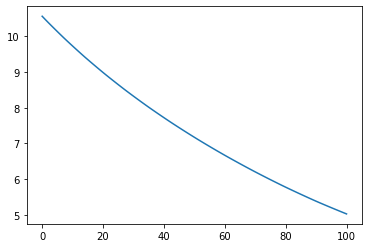

In [38]:
plt.plot(Et)

In [ ]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [ ]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

In [ ]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [ ]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

In [ ]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [ ]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [ ]:
(1-δ/(α-ioverk))/ioverk

In [ ]:
-0.0429 + ioverk - κ/2.*ioverk**2

In [ ]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

In [ ]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [ ]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])